In [182]:
import xarray as xr
import numpy as np
import glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib as mpl
from scipy.ndimage.filters import uniform_filter
from pyproj import Transformer
from datetime import datetime, timedelta
from tqdm import tqdm
import numpy.ma as ma

/tmp/ipykernel_14173/2178322309.py:8: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter


In [183]:
def generate_array(data, lonlatbox):
    """
    Generate a subarray from the given data based on the specified bounding box in longitude and latitude.

    Parameters:
    - data (xarray.Dataset): The input dataset containing the required variable ('crr_intensity').
    - lonlatbox (tuple): A tuple representing the bounding box in the form (min_lon, max_lon, min_lat, max_lat).

    Returns:
    - zam_array (numpy.ndarray): The subarray of 'crr_intensity' values.
    - x_coords (numpy.ndarray): The x coordinates corresponding to the columns of zam_array.
    - y_coords (numpy.ndarray): The y coordinates corresponding to the rows of zam_array.
    """
    
    # Extracting bounding box coordinates
    min_lon = lonlatbox[0]
    max_lon = lonlatbox[1]
    min_lat = lonlatbox[2]
    max_lat = lonlatbox[3]

    # Geostationary projection setup
    proj = ccrs.Geostationary(central_longitude=0.0, satellite_height=35785831)
    transformer_from_latlon = Transformer.from_crs("EPSG:4326", proj.to_proj4(), always_xy=True)
    
    # Transforming latlon coordinates to projection coordinates
    min_x, max_y = transformer_from_latlon.transform(min_lon, max_lat)
    max_x, min_y = transformer_from_latlon.transform(max_lon, min_lat)
    
    # Selecting the data within the specified lonlatbox
    zam = data.sel(nx=slice(min_x, max_x), ny=slice(max_y, min_y))
    
    # Extracting coordinates from the selected data
    x_coords = zam.nx.values
    y_coords = zam.ny.values
    
    # Creating a numpy array with 'crr_intensity' values
    zam_array = np.flipud(zam['crr_intensity'].values)

    return zam_array, x_coords, y_coords


In [184]:
def nowcast_obs_generator(date, sel_init_times, lonlatbox):
    
    obs_files = glob.glob('/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/*_CRR_*' + 'T*00Z.nc')

    # Filter nowcast files based on lead tim
    obs_list = []
    init_time_list = []

    # Iterate through each nowcast file
    for file in obs_files:
        
        # Extract initialization time from file name
        init_time = file[-10:-6]
        # dt_init_time = datetime.strptime(init_time, '%H%M')
        
        if init_time in sel_init_times:
            print(init_time)
            try:
                obs_data = xr.open_dataset(file)
        
                obs_array, x_coords, y_coords = generate_array(obs_data, lonlatbox)
        
                obs_list.append(obs_array)
                init_time_list.append(init_time)
            except Exception as e:
                # Print any exceptions encountered during data processing
                print(e)


    return np.array(obs_list), init_time_list


In [185]:
def nowcast_pred_generator(tinit, lead_time_mins, lonlatbox):
        
    # Retrieve file paths for nowcast and observed data
    nowcast_files = glob.glob('/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/*EXIM*' + date_tinit + '*')

    # Filter nowcast files based on lead time
    nowcast_files = [file for file in nowcast_files if file[-6:-3] in lead_time_mins]

    # Lists to store nowcast arrays, observed arrays, and initialization times
    nowcast_list = []
    init_time_list = []

    # print(nowcast_files)

    # Iterate through each nowcast file
    for file in nowcast_files:
        # print(file)
        # Extract initialization time from file name
        init_time = file[-23:-10]
        # dt_init_time = datetime.strptime(init_time, '%H%M')
        
        if init_time in tinit:
            
            try:
                nowcast_data = xr.open_dataset(file)

                nowcast_array, x_coords, y_coords = generate_array(nowcast_data, lonlatbox)

                # Append arrays and initialization time to respective lists
                nowcast_list.append(nowcast_array)
                init_time_list.append(init_time)
                
            except Exception as e:
                # Print any exceptions encountered during data processing
                print(e)
    return np.array(nowcast_list), init_time_list


In [186]:
# Zambia domain:
min_lon = 20
max_lon = 35
min_lat = -18
max_lat = -8

# # SW Zambia domain
# min_lon = 24
# max_lon = 30
# min_lat = -17
# max_lat = -14

domain = [min_lon, max_lon, min_lat, max_lat]

In [210]:
date = '20240201'
date_tinit = date + 'T0200'
init_times = ["{:02d}00".format(n) for n in range(0,14)] # initialization times of interest
lead_times = ["{:03d}".format(n*15) for n in range(1,25)] # initialization times of interest
dpi_set = 300

## Load data

In [212]:
obs_data, obs_times = nowcast_obs_generator(date, init_times, domain)

obs_data_ma = ma.masked_array(obs_data, mask=(obs_data==0))

0000
0100
0200


/home/users/khermes/miniconda3/envs/satpy_0.42.2/lib/python3.11/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


0300
0400
0500
0600
0700


In [213]:
pred_data, pred_times = nowcast_pred_generator(date_tinit, lead_times, domain)

pred_data_ma = ma.masked_array(pred_data, mask=(pred_data==0))

In [214]:
# Get projection coordinates from anz nowcast file
ipath ='/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_EXIM-CRR_MSG3_Africa-VISIR_20240129T100000Z_015.nc'
data = xr.open_dataset(ipath)
_,  x_coords, y_coords = generate_array(data = data, lonlatbox = domain)

0


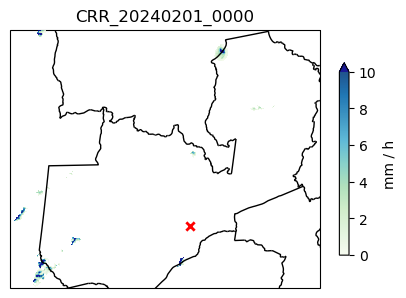

1


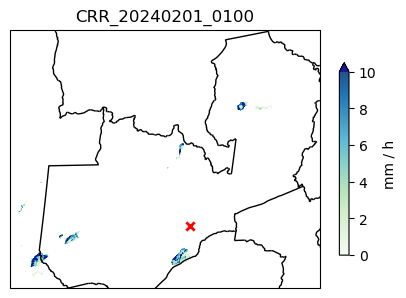

2


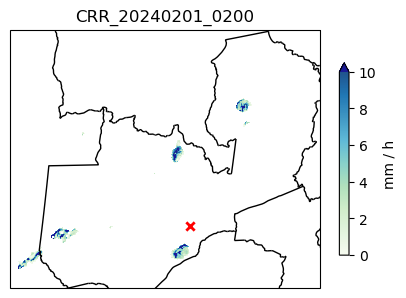

3


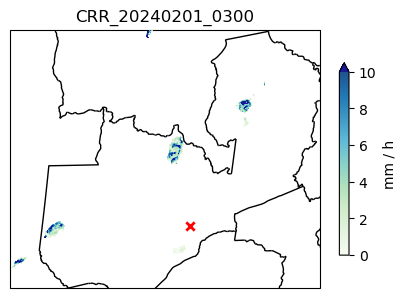

4


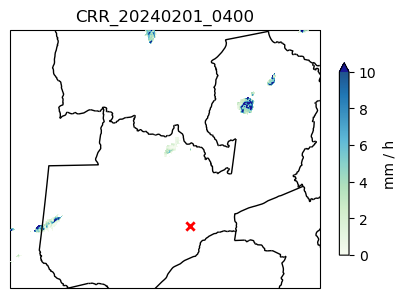

5


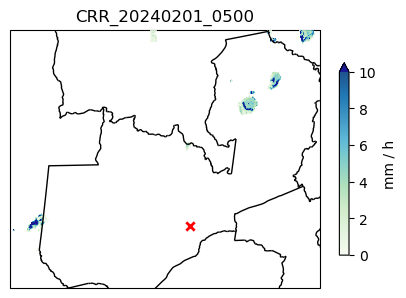

6


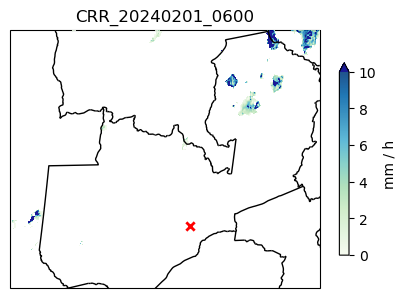

7


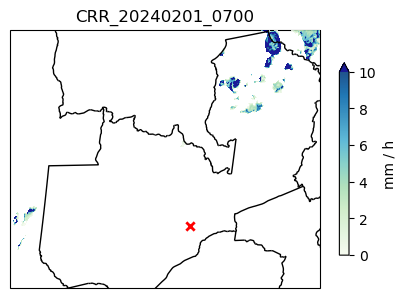

In [215]:
cbarmax = 10

# Plot CRR maps
for ii in range(obs_data_ma.shape[0]):
    print(ii)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111,projection=ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831))

    cmap = plt.get_cmap('GnBu').copy()
    cmap.set_extremes(over='darkblue')
    norm = plt.Normalize(0, cbarmax)
    
    img = ax.imshow(
        obs_data_ma[ii,:,:], origin='lower',
        extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
        zorder=10,
        alpha = 0.9,
        cmap=cmap,
        norm=norm,
    )
    
    ax.add_feature(cfeature.BORDERS, zorder=10)
    ax.coastlines(zorder=10)
    plt.title(f'CRR_{date}_{init_times[ii]}')
    
    cb = plt.colorbar(img, shrink=0.5, label='mm / h', extend = 'max')
    img.set_clim([0, cbarmax])
    
    ax.scatter(x=28.29, y=-15.4, color='red', linewidth=2, marker='x', transform=ccrs.PlateCarree()) # Lusaka

    plt.savefig(f'CRR_{date}_{init_times[ii]}', bbox_inches='tight', dpi = dpi_set)
    plt.show()



0


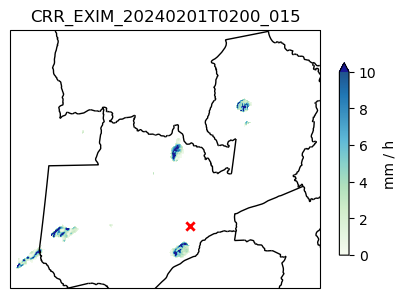

1


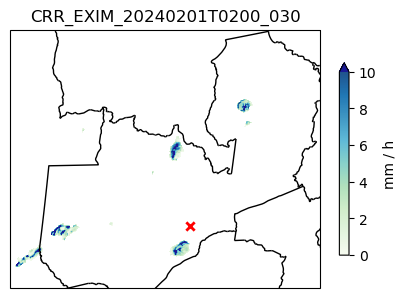

2


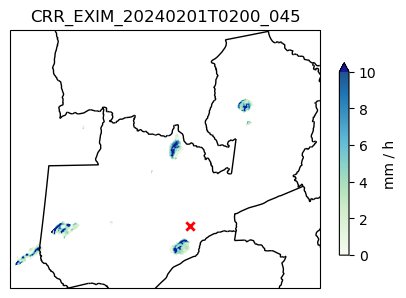

3


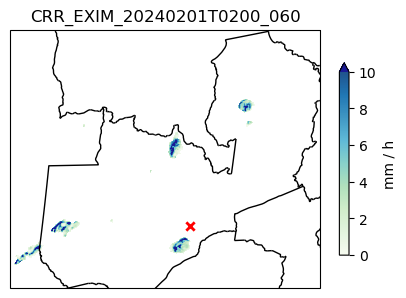

4


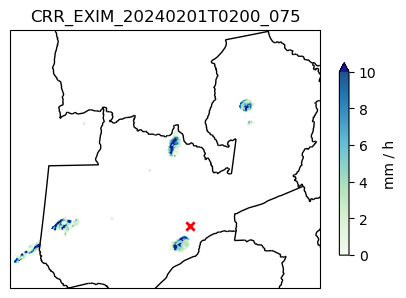

5


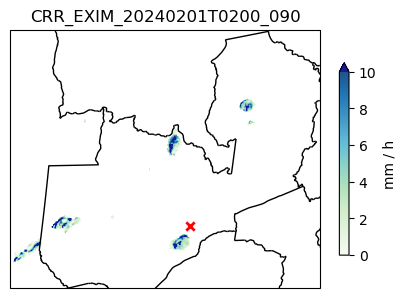

6


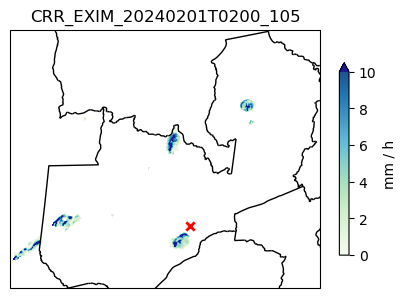

7


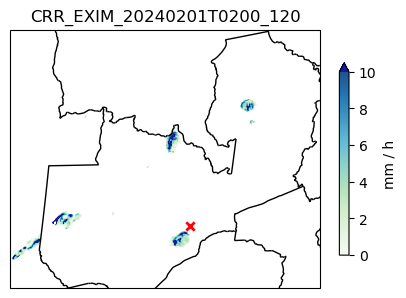

8


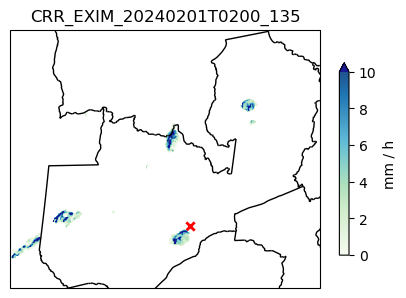

9


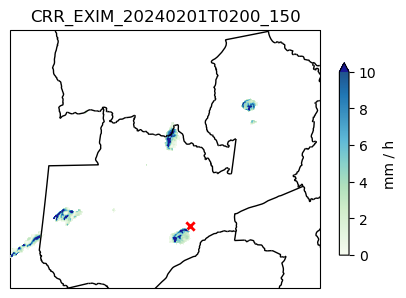

10


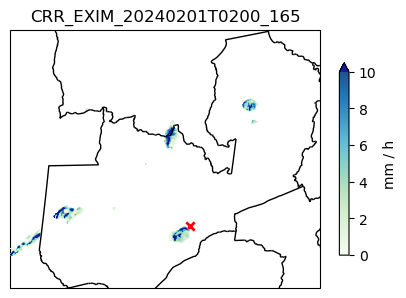

11


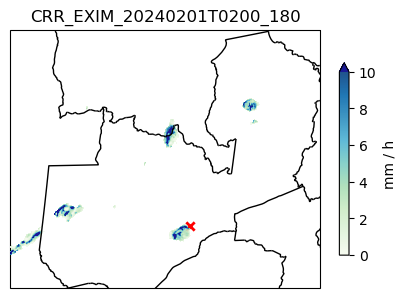

12


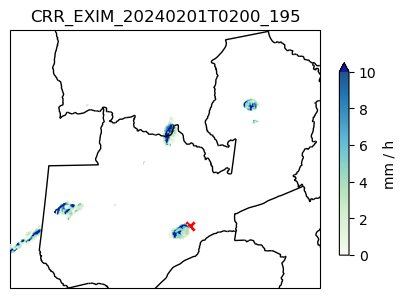

13


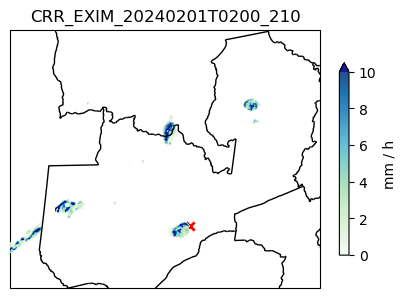

14


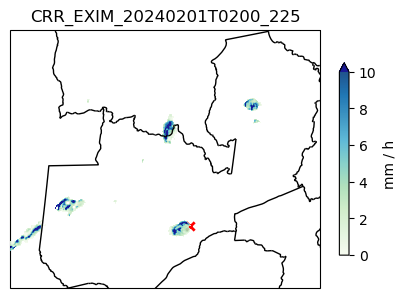

15


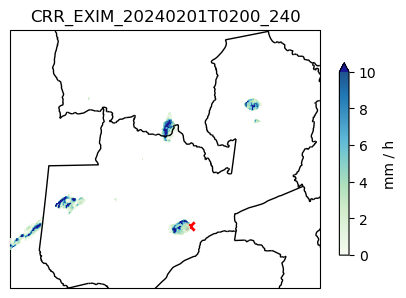

16


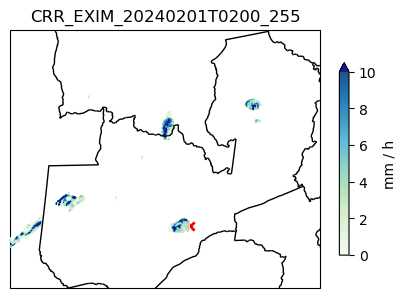

17


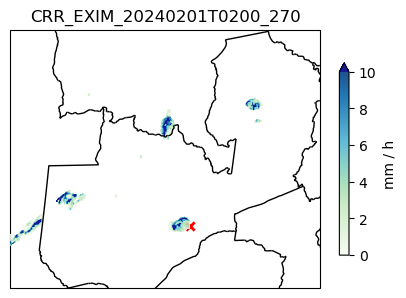

18


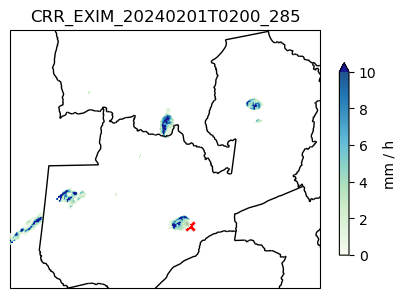

19


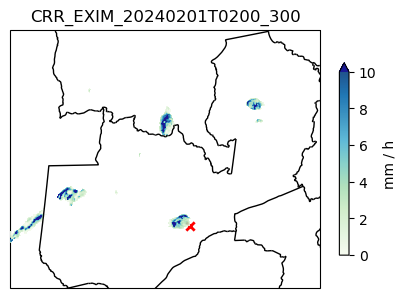

20


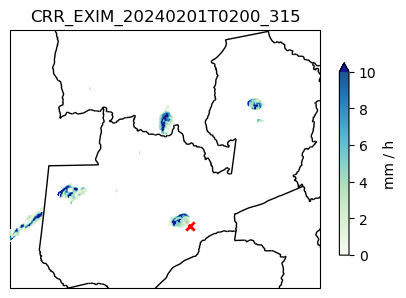

21


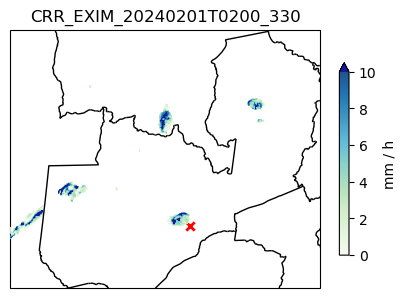

22


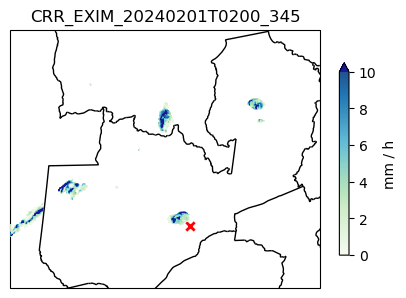

23


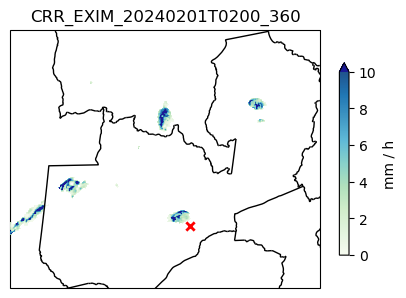

In [216]:
cbarmax = 10

# Plot CRR maps
for ii in range(pred_data_ma.shape[0]):
    print(ii)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111,projection=ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831))

    cmap = plt.get_cmap('GnBu').copy()
    cmap.set_extremes(over='darkblue')
    norm = plt.Normalize(0, cbarmax)
    
    img = ax.imshow(
        pred_data_ma[ii,:,:], origin='lower',
        extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
        zorder=10,
        alpha = 0.9,
        cmap=cmap,
        norm=norm,
    )
    
    ax.scatter(x=28.29, y=-15.4, color='red', linewidth=2, marker='x', transform=ccrs.PlateCarree()) # Lusaka

    
    ax.add_feature(cfeature.BORDERS, zorder=10)
    ax.coastlines(zorder=10)
    plt.title(f'CRR_EXIM_{date_tinit}_{lead_times[ii]}')
    
    cb = plt.colorbar(img, shrink=0.5, label='mm / h', extend = 'max')
    img.set_clim([0, cbarmax])

    plt.savefig(f'CRR_EXIM_{date_tinit}_{lead_times[ii]}', bbox_inches='tight', dpi = dpi_set)
    plt.show()

